In [1]:
# We will be using satimage data as in the Borderline-SMOTE paper
from sklearn.datasets import fetch_openml
import pandas as pd
import gc

data = fetch_openml(name='satimage')
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# treat 4 as the target class
y = (y=='4.').astype(int)
y.mean()

del data
gc.collect()

0

## How the baseline model does without any over-sampling

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                    stratify=y, shuffle=True, random_state=1024)

In [4]:
def evaluate(clf):
    pred_proba = clf.predict_proba(X_test)[:, 1]
    pred = clf.predict(X_test)
    metric = 'AUC: {}\nRecall: {}\nPrecision: {}\nF1: {}\n'.format(roc_auc_score(y_test, pred_proba),
                                                              recall_score(y_test, pred),
                                                              precision_score(y_test, pred),
                                                              f1_score(y_test, pred))
    print(metric)

In [5]:
clf = RandomForestClassifier(n_estimators=100, random_state=1024)
clf.fit(X_train, y_train)

evaluate(clf)

AUC: 0.9455910029696799
Recall: 0.4946808510638298
Precision: 0.8378378378378378
F1: 0.6220735785953178



## With SMOTE

In [6]:
from imblearn.over_sampling import SMOTE

clf.fit(*SMOTE().fit_resample(X_train, y_train))

evaluate(clf)

Using TensorFlow backend.


AUC: 0.9583755972967358
Recall: 0.6329787234042553
Precision: 0.6432432432432432
F1: 0.6380697050938338



## AutoEncoders?

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
from tensorflow import keras

# the nightly build of tensorflow_probability is required as of the time of writing this 
import tensorflow_probability as tfp
ds = tfp.distributions

import warnings
warnings.filterwarnings('ignore')

C:\Users\liuzhehao\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [8]:
def standardize(x):
    mean_, var_ = tf.nn.moments(x, axes=[0], keepdims=True)
    return (x - mean_) / tf.sqrt(var_)

In [9]:
N_FEATURE = X_train.shape[1]
BATCH_SIZE = 124

train_dataset =tf.data.Dataset.from_tensor_slices(X_train.values.astype('float32')) \
    .shuffle(10000).batch(BATCH_SIZE).map(standardize)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test.values.astype('float32')) \
    .shuffle(10000).batch(10000).map(standardize)

# all positive samples
train_pos_dataset = tf.data.Dataset.from_tensor_slices(X_train[y_train==1].values.astype('float32')) \
    .shuffle(10000).batch(BATCH_SIZE).map(standardize)
test_pos_dataset = tf.data.Dataset.from_tensor_slices(X_test[y_test==1].values.astype('float32')) \
    .shuffle(10000).batch(100).map(standardize)

In [10]:
sample = next(iter(train_pos_dataset))
sample.shape

TensorShape([124, 36])

In [11]:
def make_encoder_decoder(hidden_size=4, share_hidden=False):
    """ If share hidden is set to False, then the actual hidden_size will be 2 * hidden_size
        and it will split in half into the mean and std vector
    """
    if share_hidden is False:
        hidden_size = hidden_size * 2
        
    encoder = tf.keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(N_FEATURE,)),
        keras.layers.Dense(36, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(18, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(hidden_size)
    ])

    decoder = tf.keras.models.Sequential([
        keras.layers.Dense(18, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(36, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(N_FEATURE)
    ])
    
    return encoder, decoder

In [12]:
# take a look at the encoder and decoders
e_, d_ = make_encoder_decoder()
e_.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 36)                1332      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 36)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                666       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 152       
Total params: 2,150
Trainable params: 2,150
Non-trainable params: 0
_________________________________________________________________


In [13]:
def check_gradients(gradients):
    """ Handy function to check the gradients, in case we get nans from gradient explotion """
    grad = [i.numpy() for i in gradients]
    if all([np.isfinite(g).all() for g in grad]):
        avg_grad = [np.mean(g) for g in grad]
        mean_, std_ = np.mean(avg_grad), np.std(avg_grad)
        print('Gradients stats: mean={}, std={}'.format(mean_, std_))
    else:
        print('Gradient exploded: {}'.format(grad))

In [14]:
class VAE(tf.keras.Model):
    
    def __init__(self, learning_rate=1e-3, hidden_size=8, share_hidden=False, recon_loss_div=10.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.share_hidden = share_hidden
        self.encoder, self.decoder = make_encoder_decoder(hidden_size, share_hidden)
        self.recon_loss_div = recon_loss_div
        
        # only used when share hidden is True
        self.dense_mean = keras.layers.Dense(hidden_size)
        self.dense_std = keras.layers.Dense(hidden_size)
        
        # use for the weighted sum of latent loss and reconstruction loss
        self.latent_weight = tf.Variable(0.5, dtype=tf.float32, name='recon_loss_weight')
        
        self.learning_rate = tf.Variable(learning_rate, dtype=tf.float32, trainable=False)
        self.optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate)
        
    def reduce_learning_rate(self, factor=2):
        self.learning_rate = self.learning_rate.assign(self.learning_rate / factor)
    
    def encode(self, x):
        encoded = self.encoder(x)
        if self.share_hidden:
            mu, sigma = self.dense_mean(encoded), self.dense_std(encoded)
        else:
            mu, sigma = tf.split(encoded, num_or_size_splits=2, axis=1)
        return mu, sigma, ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def decode(self, z):
        return self.decoder(z)
    
    def compute_loss(self, x):
        mu, sigma, q_z = self.encode(x)
#         z = sigma * q_z.sample() + mu
        z = q_z.sample()
        x_recon = self.decode(z)
        
        # standard normal distribution
        p_z = ds.MultivariateNormalDiag(loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1])
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_recon), axis=0))
#         return latent_loss, recon_loss, recon_loss / self.recon_loss_div + latent_loss

        latent_weight = tf.clip_by_value(self.latent_weight, 0.1, 0.9)
        recon_weight = 1 - latent_weight
        return latent_loss, recon_loss, recon_weight * recon_loss + latent_weight * latent_loss
    
    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            latent_loss, recon_loss, loss = self.compute_loss(x)
        gradients = tape.gradient(loss, self.trainable_variables)
        return gradients
#         grad = [g.numpy() for g in gradients]
#         if all([np.isfinite(g).all() for g in grad]):
#             return gradients
#         else:
#             print('Gradient exploded.')
#             return None
        
    @tf.function
    def train(self, train_x):
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

In [15]:
n_epochs = 1500

# gradually reduce the learning rate
steps_before_reduce_learning_rate = 400
reduce_factor = 2.0

N_TRAIN_BATCHES = y_train.sum() // BATCH_SIZE
N_TEST_BATCHES = y_test.sum() // BATCH_SIZE
EARLY_STOPPING_ROUNDS = 50

losses = pd.DataFrame(columns = ['latent_loss', 'recon_loss', 'loss'])
prev_loss, early_stop_round = np.inf, 0

model = VAE(1e-3, hidden_size=6, share_hidden=False)

for epoch in tqdm(range(n_epochs), total=n_epochs):
    # reduce learning rate
    if (epoch + 1) >= steps_before_reduce_learning_rate and (epoch + 1) % steps_before_reduce_learning_rate == 0:
        model.reduce_learning_rate(reduce_factor)
        print('The learning rate now is: {}'.format(model.learning_rate))

    # train
    for batch, train_x in zip(range(N_TRAIN_BATCHES), train_pos_dataset):
        model.train(train_x)
        
    # test on holdout
    loss = []
    for batch, test_x in zip(range(N_TEST_BATCHES), test_pos_dataset):
        loss.append(model.compute_loss(test_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    
    # early stopping
    round_loss = (losses.recon_loss.values[-1] + losses.latent_loss.values[-1]) / 2
    if round_loss < prev_loss:
        early_stop_round = 0
    else:
        early_stop_round += 1
        if early_stop_round == EARLY_STOPPING_ROUNDS:
            break
    prev_loss = round_loss
    
    print(
        "Epoch: {} | recon_loss: {} | latent_loss: {} | total_loss: {}".format(
           epoch, losses.recon_loss.values[-1], losses.latent_loss.values[-1], round_loss
        ))

W0826 17:48:21.992195  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x0000000020846818> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.014197  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x0000000020AAB908> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.036199  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x0000000020AABEA8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.057201  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x0000000020AABE58> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.085204  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x0000000020ADBBD8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.109207  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x0000000020ADBF98> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.124208  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x00000000208465E8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.147210  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x0000000020E2C408> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.162212  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x0000000020E2C9A8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.180214  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x0000000020E2CCC8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.193215  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x00000000214D0098> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.208216  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x00000000214D0408> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.221218  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x00000000214D08B8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.235219  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x00000000214D0A48> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.254221  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x00000000214D0B38> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.270223  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x00000000214D0C28> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.283224  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x00000000214D0D18> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.295225  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x00000000214D0E08> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.309226  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x00000000214D0EA8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.323228  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x000000002153B098> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.338229  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x000000002153B3B8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.355231  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x000000002153B228> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.368232  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x000000002153B5E8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.382234  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x000000002153B368> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.397235  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x000000002153B638> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.409237  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x000000002153B7C8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.421238  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x000000002153B778> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.432239  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x000000002153B908> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.445240  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x000000002153B9F8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.457242  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x000000002153BAE8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.469243  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x000000002153BBD8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.484244  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x000000002153BC78> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.497245  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x000000002153BE08> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.510247  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x000000002153BEF8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.523248  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x0000000021549098> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.533249  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x00000000215493B8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.546250  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x0000000021549228> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


W0826 17:48:22.559252  6436 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x0000000021549408> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.


Epoch: 0 | recon_loss: 105.60470581054688 | latent_loss: 8.829839706420898 | total_loss: 57.2172737121582
Epoch: 1 | recon_loss: 103.01872253417969 | latent_loss: 8.631074905395508 | total_loss: 55.82489776611328
Epoch: 2 | recon_loss: 101.33224487304688 | latent_loss: 8.343873977661133 | total_loss: 54.83805847167969
Epoch: 3 | recon_loss: 100.78919219970703 | latent_loss: 8.165118217468262 | total_loss: 54.47715377807617
Epoch: 4 | recon_loss: 98.81007385253906 | latent_loss: 7.827826499938965 | total_loss: 53.31895065307617
Epoch: 5 | recon_loss: 98.27079010009766 | latent_loss: 7.681879043579102 | total_loss: 52.97633361816406
Epoch: 6 | recon_loss: 98.13070678710938 | latent_loss: 7.736872673034668 | total_loss: 52.93378829956055
Epoch: 7 | recon_loss: 96.70618438720703 | latent_loss: 7.65146017074585 | total_loss: 52.1788215637207
Epoch: 8 | recon_loss: 94.1205825805664 | latent_loss: 7.6160173416137695 | total_loss: 50.86830139160156
Epoch: 9 | recon_loss: 94.46253204345703 | la

Epoch: 145 | recon_loss: 35.294044494628906 | latent_loss: 8.006861686706543 | total_loss: 21.650453567504883
Epoch: 146 | recon_loss: 35.664093017578125 | latent_loss: 7.999433517456055 | total_loss: 21.831764221191406
Epoch: 147 | recon_loss: 34.16059112548828 | latent_loss: 7.977292537689209 | total_loss: 21.068941116333008
Epoch: 148 | recon_loss: 34.298397064208984 | latent_loss: 7.9890241622924805 | total_loss: 21.14371109008789
Epoch: 149 | recon_loss: 33.08659362792969 | latent_loss: 7.991910934448242 | total_loss: 20.53925323486328
Epoch: 150 | recon_loss: 36.26482391357422 | latent_loss: 8.002205848693848 | total_loss: 22.133514404296875
Epoch: 151 | recon_loss: 36.41569519042969 | latent_loss: 7.987678050994873 | total_loss: 22.20168685913086
Epoch: 152 | recon_loss: 35.33517837524414 | latent_loss: 7.9332194328308105 | total_loss: 21.634199142456055
Epoch: 153 | recon_loss: 34.666709899902344 | latent_loss: 7.898845195770264 | total_loss: 21.282777786254883
Epoch: 154 | rec

Epoch: 295 | recon_loss: 39.578529357910156 | latent_loss: 6.229670524597168 | total_loss: 22.90410041809082
Epoch: 296 | recon_loss: 38.903099060058594 | latent_loss: 6.223409652709961 | total_loss: 22.563255310058594
Epoch: 297 | recon_loss: 36.851715087890625 | latent_loss: 6.210999965667725 | total_loss: 21.531356811523438
Epoch: 298 | recon_loss: 36.349578857421875 | latent_loss: 6.212860584259033 | total_loss: 21.281219482421875
Epoch: 299 | recon_loss: 39.85163879394531 | latent_loss: 6.219303607940674 | total_loss: 23.035470962524414
Epoch: 300 | recon_loss: 37.413368225097656 | latent_loss: 6.229689121246338 | total_loss: 21.821529388427734
Epoch: 301 | recon_loss: 38.28263854980469 | latent_loss: 6.206340312957764 | total_loss: 22.244489669799805
Epoch: 302 | recon_loss: 38.04290008544922 | latent_loss: 6.213239669799805 | total_loss: 22.128070831298828
Epoch: 303 | recon_loss: 38.82169723510742 | latent_loss: 6.229011058807373 | total_loss: 22.525354385375977
Epoch: 304 | re

Epoch: 444 | recon_loss: 39.68938446044922 | latent_loss: 5.9572858810424805 | total_loss: 22.823335647583008
Epoch: 445 | recon_loss: 38.43242263793945 | latent_loss: 5.971928596496582 | total_loss: 22.20217514038086
Epoch: 446 | recon_loss: 37.559326171875 | latent_loss: 5.9778876304626465 | total_loss: 21.768606185913086
Epoch: 447 | recon_loss: 38.26061248779297 | latent_loss: 5.992732524871826 | total_loss: 22.126672744750977
Epoch: 448 | recon_loss: 35.59843444824219 | latent_loss: 5.955319404602051 | total_loss: 20.77687644958496
Epoch: 449 | recon_loss: 37.77458953857422 | latent_loss: 5.932182788848877 | total_loss: 21.85338592529297
Epoch: 450 | recon_loss: 34.874046325683594 | latent_loss: 5.8902668952941895 | total_loss: 20.382156372070312
Epoch: 451 | recon_loss: 41.193233489990234 | latent_loss: 5.870772838592529 | total_loss: 23.53200340270996
Epoch: 452 | recon_loss: 39.09104537963867 | latent_loss: 5.866164684295654 | total_loss: 22.478605270385742
Epoch: 453 | recon_l

Epoch: 594 | recon_loss: 37.12522888183594 | latent_loss: 5.423421859741211 | total_loss: 21.27432632446289
Epoch: 595 | recon_loss: 38.09125900268555 | latent_loss: 5.445416450500488 | total_loss: 21.76833724975586
Epoch: 596 | recon_loss: 37.18135070800781 | latent_loss: 5.471043586730957 | total_loss: 21.326196670532227
Epoch: 597 | recon_loss: 36.00945281982422 | latent_loss: 5.488447189331055 | total_loss: 20.748950958251953
Epoch: 598 | recon_loss: 37.9837532043457 | latent_loss: 5.468301296234131 | total_loss: 21.72602653503418
Epoch: 599 | recon_loss: 34.258636474609375 | latent_loss: 5.4367170333862305 | total_loss: 19.84767723083496
Epoch: 600 | recon_loss: 36.11518096923828 | latent_loss: 5.411529541015625 | total_loss: 20.763355255126953
Epoch: 601 | recon_loss: 35.60740661621094 | latent_loss: 5.384028911590576 | total_loss: 20.495718002319336
Epoch: 602 | recon_loss: 38.34607696533203 | latent_loss: 5.360528945922852 | total_loss: 21.853302001953125
Epoch: 603 | recon_los

Epoch: 744 | recon_loss: 35.50563049316406 | latent_loss: 5.058650970458984 | total_loss: 20.282140731811523
Epoch: 745 | recon_loss: 36.02708435058594 | latent_loss: 5.051197052001953 | total_loss: 20.539140701293945
Epoch: 746 | recon_loss: 32.98656463623047 | latent_loss: 5.046037673950195 | total_loss: 19.016300201416016
Epoch: 747 | recon_loss: 34.89533996582031 | latent_loss: 5.045056343078613 | total_loss: 19.970197677612305
Epoch: 748 | recon_loss: 35.19281005859375 | latent_loss: 5.059830188751221 | total_loss: 20.126319885253906
Epoch: 749 | recon_loss: 35.837215423583984 | latent_loss: 5.066617012023926 | total_loss: 20.451915740966797
Epoch: 750 | recon_loss: 35.78056335449219 | latent_loss: 5.060623645782471 | total_loss: 20.42059326171875
Epoch: 751 | recon_loss: 37.351505279541016 | latent_loss: 5.038664817810059 | total_loss: 21.195085525512695
Epoch: 752 | recon_loss: 37.84627151489258 | latent_loss: 5.022536754608154 | total_loss: 21.434404373168945
Epoch: 753 | recon

Epoch: 893 | recon_loss: 34.44292068481445 | latent_loss: 4.905273914337158 | total_loss: 19.674097061157227
Epoch: 894 | recon_loss: 37.87752914428711 | latent_loss: 4.922568321228027 | total_loss: 21.400049209594727
Epoch: 895 | recon_loss: 34.61641311645508 | latent_loss: 4.927711486816406 | total_loss: 19.772062301635742
Epoch: 896 | recon_loss: 35.919376373291016 | latent_loss: 4.925336837768555 | total_loss: 20.42235565185547
Epoch: 897 | recon_loss: 34.97077941894531 | latent_loss: 4.9267354011535645 | total_loss: 19.94875717163086
Epoch: 898 | recon_loss: 37.142005920410156 | latent_loss: 4.9185285568237305 | total_loss: 21.0302677154541
Epoch: 899 | recon_loss: 35.51011276245117 | latent_loss: 4.945797443389893 | total_loss: 20.227954864501953
Epoch: 900 | recon_loss: 35.937110900878906 | latent_loss: 4.984086990356445 | total_loss: 20.46059799194336
Epoch: 901 | recon_loss: 33.291622161865234 | latent_loss: 5.006772041320801 | total_loss: 19.14919662475586
Epoch: 902 | recon_

Epoch: 1042 | recon_loss: 34.080589294433594 | latent_loss: 4.919166088104248 | total_loss: 19.4998779296875
Epoch: 1043 | recon_loss: 36.5315055847168 | latent_loss: 4.89182710647583 | total_loss: 20.711666107177734
Epoch: 1044 | recon_loss: 36.04915237426758 | latent_loss: 4.878923416137695 | total_loss: 20.464038848876953
Epoch: 1045 | recon_loss: 35.72938537597656 | latent_loss: 4.916132926940918 | total_loss: 20.3227596282959
Epoch: 1046 | recon_loss: 37.08552932739258 | latent_loss: 4.8939948081970215 | total_loss: 20.989761352539062
Epoch: 1047 | recon_loss: 36.25204849243164 | latent_loss: 4.885395526885986 | total_loss: 20.568721771240234
Epoch: 1048 | recon_loss: 35.94537353515625 | latent_loss: 4.943177223205566 | total_loss: 20.44427490234375
Epoch: 1049 | recon_loss: 38.44001770019531 | latent_loss: 4.880741119384766 | total_loss: 21.66037940979004
Epoch: 1050 | recon_loss: 36.61647415161133 | latent_loss: 4.874202251434326 | total_loss: 20.745338439941406
Epoch: 1051 | re

Epoch: 1190 | recon_loss: 37.07209777832031 | latent_loss: 4.719696521759033 | total_loss: 20.895896911621094
Epoch: 1191 | recon_loss: 34.91484451293945 | latent_loss: 4.736621856689453 | total_loss: 19.825733184814453
Epoch: 1192 | recon_loss: 33.0937385559082 | latent_loss: 4.751407623291016 | total_loss: 18.92257308959961
Epoch: 1193 | recon_loss: 34.407569885253906 | latent_loss: 4.789690017700195 | total_loss: 19.598628997802734
Epoch: 1194 | recon_loss: 35.4616584777832 | latent_loss: 4.764329433441162 | total_loss: 20.112993240356445
Epoch: 1195 | recon_loss: 32.9072380065918 | latent_loss: 4.7401628494262695 | total_loss: 18.823699951171875
Epoch: 1196 | recon_loss: 34.504051208496094 | latent_loss: 4.711061000823975 | total_loss: 19.607555389404297
Epoch: 1197 | recon_loss: 35.07851028442383 | latent_loss: 4.726526260375977 | total_loss: 19.90251922607422
Epoch: 1198 | recon_loss: 36.2088508605957 | latent_loss: 4.725525379180908 | total_loss: 20.467187881469727
The learning 

Epoch: 1337 | recon_loss: 36.62559509277344 | latent_loss: 4.573198318481445 | total_loss: 20.599395751953125
Epoch: 1338 | recon_loss: 32.563804626464844 | latent_loss: 4.668681621551514 | total_loss: 18.616243362426758
Epoch: 1339 | recon_loss: 35.48129653930664 | latent_loss: 4.773203372955322 | total_loss: 20.12725067138672
Epoch: 1340 | recon_loss: 34.99110794067383 | latent_loss: 4.770096302032471 | total_loss: 19.88060188293457
Epoch: 1341 | recon_loss: 35.40678024291992 | latent_loss: 4.715961456298828 | total_loss: 20.061370849609375
Epoch: 1342 | recon_loss: 36.958892822265625 | latent_loss: 4.697457313537598 | total_loss: 20.828174591064453
Epoch: 1343 | recon_loss: 38.12636184692383 | latent_loss: 4.648176670074463 | total_loss: 21.387269973754883
Epoch: 1344 | recon_loss: 38.871124267578125 | latent_loss: 4.608450412750244 | total_loss: 21.739788055419922
Epoch: 1345 | recon_loss: 36.50068664550781 | latent_loss: 4.584913730621338 | total_loss: 20.542800903320312
Epoch: 13

Epoch: 1485 | recon_loss: 34.93385696411133 | latent_loss: 4.499505043029785 | total_loss: 19.7166805267334
Epoch: 1486 | recon_loss: 36.34128189086914 | latent_loss: 4.487203598022461 | total_loss: 20.414241790771484
Epoch: 1487 | recon_loss: 37.1698112487793 | latent_loss: 4.4817399978637695 | total_loss: 20.825775146484375
Epoch: 1488 | recon_loss: 34.819950103759766 | latent_loss: 4.479227066040039 | total_loss: 19.64958953857422
Epoch: 1489 | recon_loss: 34.69108963012695 | latent_loss: 4.5096964836120605 | total_loss: 19.600393295288086
Epoch: 1490 | recon_loss: 34.70750427246094 | latent_loss: 4.55980110168457 | total_loss: 19.633651733398438
Epoch: 1491 | recon_loss: 33.6994743347168 | latent_loss: 4.557763576507568 | total_loss: 19.128618240356445
Epoch: 1492 | recon_loss: 37.140769958496094 | latent_loss: 4.581179141998291 | total_loss: 20.86097526550293
Epoch: 1493 | recon_loss: 33.967445373535156 | latent_loss: 4.561911106109619 | total_loss: 19.264678955078125
Epoch: 1494 

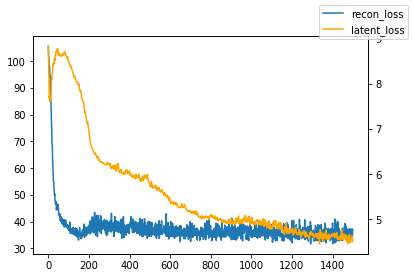

In [16]:
# plot the loss throughout the training
import matplotlib.pyplot as plt
%matplotlib inline

ax = plt.subplot(1, 1, 1)
ax.plot(losses.index, losses.recon_loss, label='recon_loss')

ax2 = ax.twinx()
ax2.plot(losses.index, losses.latent_loss, label='latent_loss', color='orange')
ax.figure.legend(loc='best')

In [169]:
# save the model
model.save_weights('./vae_1_weights.h5')

## Model perfomance with no lable at all

In [136]:
# evaluate
p_z = ds.MultivariateNormalDiag(loc=[0.] * model.hidden_size, scale_diag=[1.] * model.hidden_size)

test_tensor = tf.constant(X_test.values, dtype='float32')
# mu, sigma = tf.split(model.encoder(test_tensor), 2, 1)
encoded = model.encoder(test_tensor)
mu, sigma = model.dense_mean(encoded), model.dense_std(encoded)

q_z = ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
test_pred = ds.kl_divergence(p_z, q_z)
# test_pred = tf.sigmoid(test_pred)

test_pred = test_pred.numpy()
test_pred = test_pred / (test_pred.max() - test_pred.min())

In [56]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, test_pred)

0.7206637173549073

## Use labels to generate oversampled data

In [17]:
# number of positive samples to generate so the minority class has the same amount as majority clas
n = (y_train == 0).sum() - (y_train==1).sum()
print('Need to generate {} positive samples.'.format(n))

Need to generate 3627 positive samples.


In [18]:
X_train_pos = X_train[y_train==1]

_, _, ds_pos = model.encode(X_train_pos.values)
sample_pos = ds_pos.sample(sample_shape=(n // y_train.sum()) + 1, seed=1024)
sample_pos = tf.reshape(sample_pos, [-1, model.hidden_size])
sample_pos = model.decode(sample_pos)
sample_pos.shape

TensorShape([3933, 36])

In [19]:
# append new samples to original samples
X_ = np.r_[X_train.values, sample_pos.numpy()[:n, ...]]
y_ = np.append(y_train, [1] * n)

# shuffle it 
from sklearn.utils import shuffle
X_, y_ = shuffle(X_, y_, random_state=1024)

In [20]:
clf.fit(X_, y_)

evaluate(clf)

AUC: 0.9428321336478179
Recall: 0.5957446808510638
Precision: 0.7671232876712328
F1: 0.6706586826347305

